## Fed-batch fermentation

The purpose of this example/tutorial is to show the advantage of using fed-batch fermenters. The notes will guide you into calculations that you will have to perform yourself in order to understand the core principles of this fermentation mode. Numerous microbes have slow growth rates when exposed to high substrate concentrations. Accordingly all the substrate cannot be added at the start of the fermentation (like all the batch fermenter examples that we have done up to now). To keep the substrate concentration in the fermenter low, substrate can be added continuously to compensate for the consumption of substrate by the microbes. We will show how this strategy is highly beneficial to productivity and hence the economics of the process.

The mathematical description of the fermentation process will alter slightly since the liquid volume in the fermenter will increase as time progress. It will be shown how the cmol balance can be adapted to incorporate the continuous feed of substrate (glucose). Have a look at this video to get started:

[Video: Lecture 18: Gradual addition of substrate](https://youtu.be/xXjsjX2ULxw)

As example we'll use a _Lactobacillus_ strain that is severely inhibited by high glucose concentrations. Lactic acid will be the sole excreted metabolite in the example. Let's jump in by setting up the flux model for the organism. The necessary theory will follow as we progress through the problem. The metabolic map is given below:

<img src="lacmap1.png" width="450" />


The following physiological parameters will be used:


|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$
|----|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$
|0.05|1.8|0.4|0.09

Let's assume the standard biomass formula of $CH_{1.8}O_{0.5}N_{0.2}$.

The growth and maintenance functions are given below:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} \left[1+\frac{C_S}{K_S} \right]^{-1}$$

$$\theta=\theta_{max}\left[\frac{Cs}{Km+Cs}\right]$$

Parameters are defined in the cell below:

In [72]:
Km, Kp, Ks = 0.001, 4, 0.5

mumax, thetamax, gamma = 0.4, 0.09, 1.8

Let's start by plotting the glucose inhibition characteristics. Ignore the formation of product for now and plot $\mu$ as a function of $C_S$. You should get something like this:

<img src="mu_vs_cs1.png" width="550" />

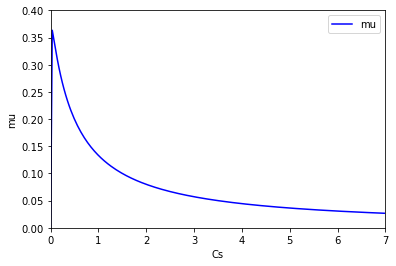

In [73]:
import numpy
import matplotlib.pyplot as plt
Cs_vals = numpy.linspace(0,7,200)

mu_vals = mumax * Cs_vals/(Km + Cs_vals) * (1 + Cs_vals/Ks)**(-1) 

plt.figure(1)
plt.plot(Cs_vals, mu_vals, color='b', label = 'mu')
plt.legend(loc='best')
plt.ylabel('mu') 
plt.xlabel('Cs') 
plt.axis([0,7,0.0,0.4])
plt.show()

Set up the response function and integrate a batch fermenter where $C_{Xo}$ and $C_{So}$ is given by:

In [88]:
Cxo=0.003  #cmol\L
Cso=6      #cmol/L

In [89]:
alpha= 0.05

C, H, O, N = 1, 1.8, 0.5, 0.2

DOR = C*4 + H + O*(-2) + N*(-3)

import numpy

S = numpy.matrix([[-1,0,1,1],
                  [-4,2,0,DOR],
                  [0,0,0,1],                  
                  [0,0,1,0]])  

C = numpy.matrix([[0,0,1,alpha]]).T
Y = numpy.linalg.solve(S,C)
beta = float(Y[1])
print("beta =", float(Y[1]))

beta = 3.608224830031759e-16


In [90]:
def response_fun1(C):
    
    Cs, Cx, Cp = C          
    mu = mumax* (Cs/(Km+Cs)) * (1+Cp/Kp)**(-1) * (1+Cs/Ks)**(-1)
    theta=thetamax*Cs/(Km+Cs)
    
    
    S = numpy.matrix([[-1,(1+alpha),1],
                  [0,1, 0],
                  [0, -gamma, 1/3]])  



    C = numpy.matrix([[0,mu,theta]]).T


    r = numpy.linalg.solve(S,C)
        
    return [-r[0,0],
             r[1,0],   
             r[2,0]]                                                    


In [91]:
def ferm_eq1(C,t):
    Cs, Cx, Cp = C[0],C[1],C[2]
    r=response_fun1([Cs, Cx, Cp])     
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]  

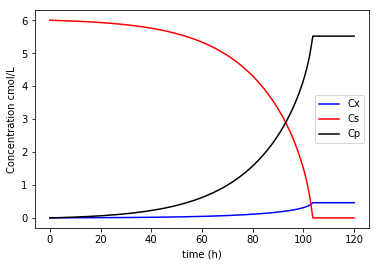

In [93]:
from scipy.integrate import odeint

Co=[Cso, Cxo, 0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax_bat=180                                   # Integrate for 20 hours  
tspan_bat=numpy.linspace(0,tmax_bat,200)           # define the timespan of the integration
Ci_bat = odeint(ferm_eq1, Co, tspan_bat)             # integration via odeint that calls apon ferm_eq

Cs_bat=Ci_bat[:,0]                                  
Cx_bat=Ci_bat[:,1]
Ce_bat=Ci_bat[:,2]

plt.figure(2)
plt.plot(tspan, Cx_bat, color='b', label='Cx')
plt.plot(tspan, Cs_bat, color='r', label='Cs')
plt.plot(tspan, Ce_bat, color='k', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

In [79]:
def response_fun2(C):
    
    Cs, Cx, Cp = C          
    mu = mumax* (Cs/(Km+Cs)) * (1+Cp/Kp)**(-1)
    theta=thetamax*Cs/(Km+Cs)
    
    
    S = numpy.matrix([[-1,(1+alpha),1],
                  [0,1, 0],
                  [0, -gamma, 1/3]])  



    C = numpy.matrix([[0,mu,theta]]).T


    r = numpy.linalg.solve(S,C)
        
    return [-r[0,0],
             r[1,0],   
             r[2,0]]     

In [80]:
def ferm_eq2(C,t):
    Cs, Cx, Cp = C[0],C[1],C[2]
    r=response_fun2([Cs, Cx, Cp])     
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]  

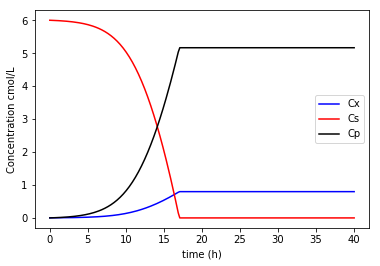

In [81]:
Co=[Cso, Cxo, 0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=40                                   # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,200)           # define the timespan of the integration
Ci = odeint(ferm_eq2, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cs1=Ci[:,0]                                  
Cx1=Ci[:,1]
Ce1=Ci[:,2]

plt.figure(2)
plt.plot(tspan, Cx1, color='b', label='Cx')
plt.plot(tspan, Cs1, color='r', label='Cs')
plt.plot(tspan, Ce1, color='k', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Repeat the integration but omit the substrate inhibition term, accordingly:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} $$

Compare the profiles of the two scenarios. You should get something like this:

<img src="batch_compare1.png" width="850" />


Make sure to note major difference in the time it takes to complete the fermentation. Remember for the process engineer time is equivalent to money. So it should be evident that the substrate inhibition effect ($\left[1+\frac{C_S}{K_S} \right]^{-1}$) is not good for productivity.

We now want to adress the issue by gradually adding glucose to the fermenter. To do this we need to consider the original cmol component balance given in [section 5.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/5%20Basic%20bioreactor%20modeling/The%20fermenter%20equation.ipynb):

$$\frac{dN_i}{dt}=Q^F C^F_i-QC_i  + r_i C_X V $$  

Since there will be no outlet flow from the fermenter, the equation will reduce to:

$$\frac{dN_i}{dt}=Q^F C^F_i + r_i C_X V $$

Note that the superscript $^F$ is used for the feed stream. The change in fermenter volume will be given by:

$$\frac{dV}{dt}=Q^F$$

To incorporate these equations we need to alter the fermenter equation in the code. The easiest route is to integrate the cmol amounts ($N_i$) and to calculate concentration afterwards given the known cmol amounts and volume ($C_i=\frac{Ni}{V}$). The response function will remain the same and will still be described by concentrations. We will also add volume ($V$) as an additional variable to the fermenter equation in order to incorporate the volume change within the fermenter equation. Below is the incomplete fermentation equation:


In [106]:
def ferm_eq(N,t):
    Cs, Cx, Cp, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3]  # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun([Cs, Cx, Cp])                        # same as before
    
    return [r[0]*Cx*V + Qf*Csf,
            r[1]*Cx*V,
            r[2]*Cx*V,
            Qf]  # Complete this on your own 

Make sure you understand that $N=[N_X, N_S, N_P, V]$ is passed between the integration function (**odeint**) and the fermentation equation (**ferm_eq**). The initial condition will thus consist out of cmol amounts and volume and not just concentrations like we had in our batch fermenter models.

In the end we still want to plot concentrations. These can be obtained after the integration is completed by merely deviding with the volume at the specific instant in time:

$$C_i(t)=\frac{N_i(t)}{V(t)}$$

To test whether you understand the description above, you need to model the fed-batch fermenter on your own. You can use the following conditions:

In [116]:
V, Csf, Qf = 1000, 400/30, 8  #L, cmol/L, L/h
Cso, Cxo = 0.1, 0.003          #cmol/l

In [117]:
def response_fun(C):
    
    Cs, Cx, Cp = C          
    mu = mumax* (Cs/(Km+Cs)) * (1+Cp/Kp)**(-1) * (1+Cs/Ks)**(-1)
    theta=thetamax*Cs/(Km+Cs)
    
    S = numpy.matrix([[-1,(1+alpha),1],
                  [0,1, 0],
                  [0, -gamma, 1/3]])  
    C = numpy.matrix([[0,mu,theta]]).T
    r = numpy.linalg.solve(S,C)
        
    return [-r[0,0],
             r[1,0],   
             r[2,0]]   

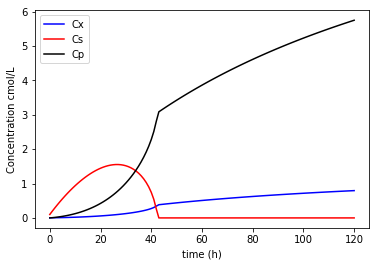

In [118]:
No=[Cso*V, Cxo*V, 0, V]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=120                                   # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,121)           # define the timespan of the integration
Ni = odeint(ferm_eq, No, tspan)             # integration via odeint that calls apon ferm_eq


Cs=Ni[:,0]/Ni[:,3]                                 
Cx=Ni[:,1]/Ni[:,3]
Ce=Ni[:,2]/Ni[:,3]

plt.figure(3)
plt.plot(tspan, Cx, color='b', label='Cx')
plt.plot(tspan, Cs, color='r', label='Cs')
plt.plot(tspan, Ce, color='k', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Take your time and think carefully. See this as a test of your understanding of the Python code used upto now. One should not confuse $C_{So}$ with $C_S^F$, $C_{So}$ is the initial glucose concentration in the fermenter, while $C_S^F$ is the glucose concentration in the stream that is fed to the fermenter. $C_S^F$ will typically be high since we don't want to increase the volume of the fermenter by too much.

If you are good, you will end with something like this:

<img src="fedbatch11.png" width="550" />

There is a lot to analyse given this picture:

The first thing to realise is that the fermentation won't stop like our previous batch fermentations. As long as we add sugar the fermentation will continue. When comparing the above graph to the previous batch fermentation, you will see that it took approximately 110 hours to reach a lactic acid concentration of $5.5\frac{cmol}{L}$ compared to the approximately 150 hours of the batch fermenter. From a productivity perspective this will make the bioprocess engineer smile.

If you calculate the volume after 120 hours you will note that the fermenter volume has almost doubled (1960 $L$). The fermentation has to stop when the fermenter is full and this will depend on the physical size of the fermenter itself. We will base the productivity of the fermenter on the final liquid volume of the fermenter. Compare the productivity of the batch and fed-batch system, by using the final product concentration in the batch fermenter as the endpoint. 

[1.07 & 1.5 $\frac{g}{L \cdot h}$] 

The glucose concentration against time had an interesting characteristic. There is an initial bump followed by an **almost zero** 'regime' of $C_S$. This relates to the amount of biomass in the fermenter ($C_X$) and the constant addition rate of glucose. Initially $C_X$ is not enough to consume all the added glucose and accordingly there is accumulation of glucose. As $C_X$ is increased the condition is reversed up to the point where **all glucose fed is immediately consumed**. This occurs at around 43 hours. For the remainder of the fermentation the glucose addition rate controls the growth and production of lactic acid. Play around with changing $Q^F$ and see whether the profiles make sense. Remember that high $C_S$ will inhibit $\mu$ and that the magnitude of $\mu$ determines the uptake of glucose.


In [119]:
prod = max(Ce_bat)*30.03
time =  tspan_bat[numpy.argmax(Ce_bat==max(Ce_bat))]
P = prod/time
P

1.065176048327388

In [120]:
time2 = numpy.interp(max(Ce_bat), Ce, tspan )
P2 = prod/time2
P2

1.4972159057775229

Let's now plot $\mu$ as a function of time. You can use the code below to convert your $N$ matrix to a $C$ matrix in order to run the asarray command like before:

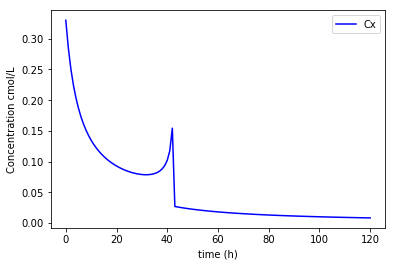

In [121]:
from numpy import asarray
Ci=(Ni[:, :3].T/Ni[:, 3]).T                   #first 3 elements of N devided by 4th element to get Ci, 
r=numpy.asarray([response_fun(C) for C in Ci])


plt.figure(4)
plt.plot(tspan, r[:,1], color='b', label='Cx')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

You should obtain the following:

<img src="mu_vs_time1.png" width="600" />

Interesting. In the first regime up to 43 hours $\mu$ is clearly influenced by $C_S$ where high $C_S$ gives low $\mu$ values. This is a direct influence of the $\left[1+\frac{C_S}{K_S} \right]^{-1}$ term.

In the second regime beyond 43 hours we have a scenario where the $C_S$ values are very low and accordingly the Monod term ($ \left[\frac{Cs}{Km+Cs} \right] $) has a major effect on $\mu$. Note that though $C_S$ might appear to be approaching zero, it has a magnitude that controls the value of $\mu$ that is non-zero as observed above.

Considering the glucose balance we have the following:

$$\frac{dN_S}{dt}=Q^F C^F_S + r_S C_X V $$

Determine the value of the two non-differential terms at 90 and 120 hours [106.67 and -106.67 $\frac{cmol}{h}$ for both times]

This should tell you that whatever gets added, gets consumed and that no accumulation of glucose is occurring. The chemical engineer will say that the glucose balance is at steady state. 

Convince yourself from the equation above that $r_S$ must decrease as time progress in regime 2. This will cause $\mu$ to decrease as observed above.




In [126]:
answer = Qf*Csf
print(answer)

dNs = ferm_eq(Ni[90],0)
rsCxV = dNs[0] - answer
rsCxV

106.66666666666667


-106.66723334909312

### Further improving productivity:

The issue in the fed-batch fermenter above was that we fed too much glucose initially (at low $C_X$) and too little towards the end of the fermentation (at high $C_X$). Let's consider increasing $Q^F$ as time progress. We can use the simple liner function:

$$Q^F=kt$$

Note that you will have to calculate $Q^F$ within the time dependent fermenter equation since it not a constant anymore. Use a k value of $1 \frac{L}{h^2}$ and see if you can generate the following graph:

<img src="fedbatch21.png" width="600" />


In [139]:
def ferm_eq(N,t):
    Cs, Cx, Cp, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3]  # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun([Cs, Cx, Cp])                        # same as before
    
    return [r[0]*Cx*V + k*t*Csf,
            r[1]*Cx*V,
            r[2]*Cx*V,
            k*t]  # Complete this on your own 

In [142]:
V, Csf, k = 1000, 400/30, 1.2  #L, cmol/L, L/h
Cso, Cxo = 0.1, 0.003          #cmol/l

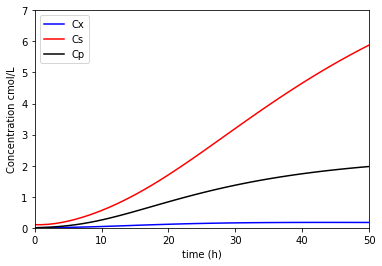

In [143]:
No=[Cso*V, Cxo*V, 0, V]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=50                                   # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,50)           # define the timespan of the integration
Ni = odeint(ferm_eq, No, tspan)             # integration via odeint that calls apon ferm_eq


Cs=Ni[:,0]/Ni[:,3]                                 
Cx=Ni[:,1]/Ni[:,3]
Ce=Ni[:,2]/Ni[:,3]

plt.figure(4)
plt.plot(tspan, Cx, color='b', label='Cx')
plt.plot(tspan, Cs, color='r', label='Cs')
plt.plot(tspan, Ce, color='k', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.axis([0,50,0,7])
plt.show()

Convince yourself that the productivity at the previous $C_P$ final value is now $3.9 \frac{g}{L \cdot h}$. Much better than before, **but why?** What is the ever increasing value of  $Q^F$ doing to $\mu$ and $r_P$ in the 'second regime'?

Increase the k value to $1.2 \frac{L}{h^2}$ and see if you can get this:

<img src="fedbatch31.png" width="600" />

What is happening here? It is as if the microbes are saying: "you have overstayed your welcome!". What is the mathematical cause for the unfavourable event?

### CBI310 higher grade (won't be asked in exam)

Given the major productivity improvement that we have obtained by adjusting the flowrate with time, the greedy bioprocess engineer will be interested in the optimum flowrate addition function. We can start by finding the $C_S$ value that will optimise $\mu$ in the function:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} $$

Repeat the $\mu$ vs $C_S$ plot that we had at the beginning of the example, but choose a much smaller $C_S$ span. You will see the $C_S=0.022 \frac{cmol}{L}$ gives the highest $\mu$. If we can operate the fermenter at this $C_S$ value we'll have the perfect balance between substrate inhibition and Monod inhibition. But how do we manipulate $Q^F$ in order to keep $C_S$ constant?  

We need to calculate $Q^{\,f}$ such that  $\frac{dC_S}{dt}=0$. If this is obeyed $C_S$ will remain at the initial value of $C_S^o$. The following manipulation can be performed to obtain the function for $Q^{\,f}$:

$$\frac{dN_S}{dt}=V\frac{dC_S}{dt}+C_S \frac{dV}{dt}  $$

$$\frac{dV}{dt}=Q^{\,f} $$

$$ \frac{dC_s}{dt}=\frac{1}{V} \left[ \frac{dN_S}{dt}-C_S Q^{\,f} \right]=0 $$

$$Q^{\,f}= \frac{1}{C_S} \frac{dN_S}{dt}=\frac{1}{C_S} \left[Q^fC_s^f+r_S C_XV \right]$$

$$Q^{\,f}= \frac{r_S C_XV}{C_S-C_S^f} $$

You now need to implement this fancy control strategy into the **fermenter equation**. If successful you will bring the productivity up to $7.5 \frac{g}{L \cdot h}$ at the $C_P^{\text{final}}$ used before.

[Back to Contents page](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/List%20of%20contents.ipynb)